# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Isoforms-Identified-in-all-Genotypes" data-toc-modified-id="Isoforms-Identified-in-all-Genotypes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Isoforms Identified in all Genotypes</a></div><div class="lev1 toc-item"><a href="#Number-of-Differentially-Expressed-Genes-(DEG)-in-each-genotype" data-toc-modified-id="Number-of-Differentially-Expressed-Genes-(DEG)-in-each-genotype-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Number of Differentially Expressed Genes (DEG) in each genotype</a></div><div class="lev1 toc-item"><a href="#Perturbation-Distributions" data-toc-modified-id="Perturbation-Distributions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perturbation Distributions</a></div><div class="lev1 toc-item"><a href="#Transcriptomic-overlap-between-gene-pairs" data-toc-modified-id="Transcriptomic-overlap-between-gene-pairs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transcriptomic overlap between gene pairs</a></div>

In this notebook, I will go over the basic results from the RNA-seq in what is essentially a top-level view of the results. Nothing specific, mainly numbers, some histograms and that's it. 

First, I will load a number of useful libraries. Notable libraries to load are `genpy`, a module that contains useful graphing functions tailored specifically for this project and developed by us; `morgan` a module that specifies what a Morgan object and a McClintock object are, and `gvars`, which contains globally defined variables that we used in this project.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import morgan as morgan
import genpy
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

Next, I will specify my q-value cutoff. A typical value for RNA-seq datasets is q=0.1 for statistical significance. I will also initialize a `genvar.genvars` object, which contains all of the global variables used for this project.

In [2]:
q = 0.1
# this loads all the labels we need
genvar = gvars.genvars()

Now, I will prepare to initialize a Morgan project. Morgan objects have a large number of attributes. I wrote the Morgan library, but over the past year it has become deprecated and less useful. We will load it here, but it's a bit messy. I am in the process of cleaning it up.

So what does a Morgan object do?

Well, when you initialize a Morgan object, you must pass at least a set of 4 strings. These strings are, in order, the column where the isoform names (unique) reside, the name of the column that holds the regression coefficient from sleuth; the name of the column that holds the TPM values passed by Kallisto and the name of the column that holds the q-values.

Next, we can add what I call a genmap. A genmap is a file that maps read files to genotypes. A genmap file has three columns: 'project_name', 'genotype' and 'batch' in that exact order. For this project, the genotypes are coded. In other words, they are letters, 'a', 'b', 'd',... and not specific genotypes. The reason for this is that we wanted to make sure that, at least during the initial phase of the project, I could not unduly bias the results by searching the literature and what not.  Because the genotypes are coded, we need to specify which of the letters represent single mutants, and which letters represent double mutants. I also need to be able to figure out what the individual components of a double mutant are. Finally, we need to set the q-value threshold. If no q-value is specified, the threshold defaults to 0.1.

I will now initialize the object. I call it thomas. Then I will load in all the variables we will use; I will load in the genmap, and at last I will load in the datasets that contain the TPM and the Sleuth $\beta$ coefficients. After everything has been loaded, I will call `thomas.filter_data`, which drops all the rows that have a $\beta$ coefficient equal to NaN

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# Specify which letters are double mutants and their genotype
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
# add the names of the single mutants
thomas.add_single_mutant(single_mutants)
# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')
# load all the beta values for each genotype:
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
        
thomas.filter_data()

Finally, we will place all the data in a tidy dataframe, where each row is an observation.

In [4]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.mapping[key]
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]
tidy = pd.concat(frames)

# I will make a new column, called absb where I place the absolute val of b
tidy['absb'] = tidy.b.abs()

# sort_values according to their position in the sorter column
# (makes sure single mutants are clustered and doubles are clustered)
tidy.sort_values('sorter', inplace=True)

# Isoforms Identified in all Genotypes

In [5]:
total_genes_id = tidy.target_id.unique().shape[0]
print("Total isoforms identified in all genotypes: {0}".format(total_genes_id))

Total isoforms identified in all genotypes: 18685


We identified 18685 isoforms using 7 million reads. Not bad considering there are ~25,000 isoforms in C. elegans. Each gene has just slightly over 1 isoform on average, so what this means is that we sampled almost 80% of the genome.

# Number of Differentially Expressed Genes (DEG) in each genotype

Next, let's figure out how many *genes* were differentially expressed in each mutant relative to the wild-type control.

In [6]:
print('Genotype: DEG')
for x in tidy.genotype.unique():
    # select the DE isoforms in the current genotype:
    sel = (tidy.qval < q) & (tidy.genotype == x)
    # extract the number of unique genes:
    s = tidy[sel].ens_gene.unique().shape[0]
    print(
"""{0}: {1}""".format(x, s))

Genotype: DEG
rhy-1: 2104
egl-9: 1807
vhl-1: 690
hif-1: 547
fog-2: 2091
egl-9;vhl-1: 2377
egl-9;hif-1: 405


From the above exploration, we can already conclude that:
 * *hif-1(lf)* has a transcriptomic phenotype
 * *hif-1;egl-9(lf)* has a transcriptomic phenotype
 * The *egl-9* phenotype is stronger than the *vhl-1* or the *hif-1* phenotypes.

We should be careful is saying whether *rhy-1*, *egl-9* and *egl-9;vhl-1(lf)* are different from each other, and the same goes for *hif-1(lf)*, *vhl-1(lf)* and *egl-9;hif-1(lf)* because we set our FDR threshold at 10%. Notice that *egl-9(lf)* and *rhy-1(lf)* are barely 300 genes separated from each other. A bit of wiggle from both, and they might be identical. 

# Perturbation Distributions

Another thing we could do is plot the distribution of effect sizes for each genotype for genes that showed statistically significant perturbations. Because of the large number of points, we should expect a spread large enough that every mutant will probably overlap. This next plot is not very informative, but always useful to look at. 

In the plot below, each line within the box represents a quartile (25, 50 and 75%) and the whiskers represent the rest of the distribution, *sans* outliers. The outliers are the black dots outside the whiskers.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

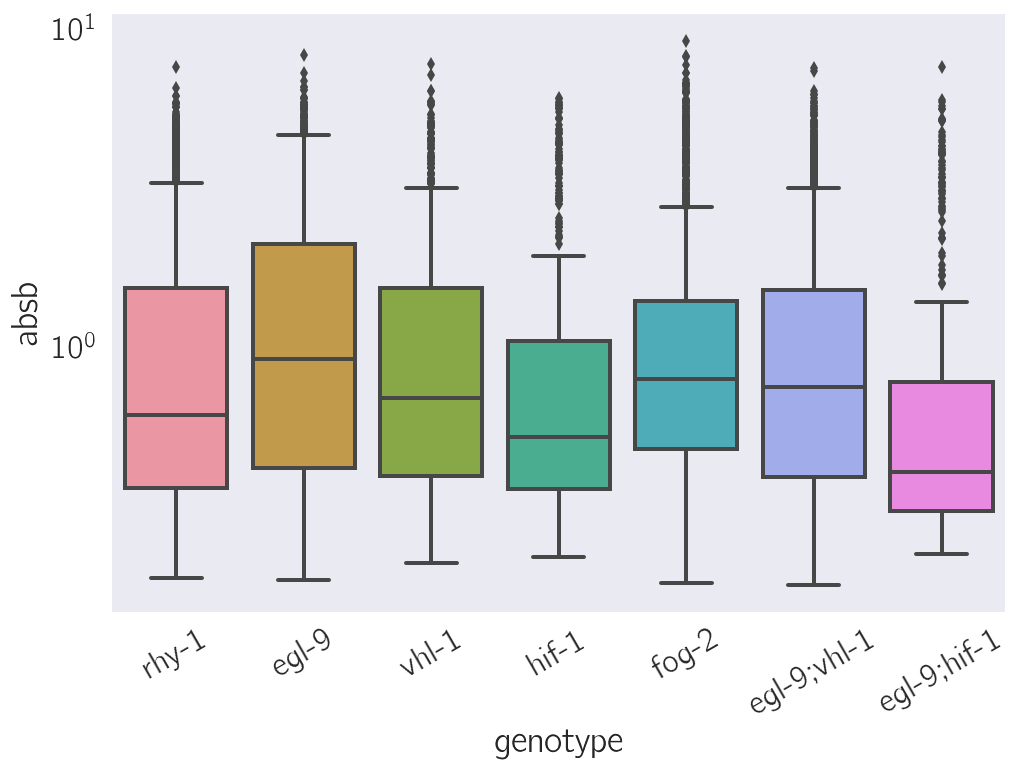

In [7]:
sns.boxplot(x='genotype', y='absb', data=tidy[tidy.qval < q])
plt.yscale('log')
plt.xticks(rotation=30)

We can see that *egl-9* genotypes have the largest median effect size of the hypoxia pathway mutants, but all genotypes have overlapping distributions. How much can we gain from this? Probably not a whole lot... At any rate, it goes to show that *egl-9(lf)* does have the most severe phenotype transcriptomically, much like its macroscopic counterparts.

# Transcriptomic overlap between gene pairs

In order to be able to assess whether two genes are interacting, we must first determine that the mutants we are studying act upon the same phenotype. What defines a phenotype in transcriptomic space? We use an operational definition -- two genotypes share the same phenotype if they regulate more than a pre-specified(and admittedly subjective) number of genes in common between the two of them, angostic of direction. Let's figure out to what extent the genes we have studied share the same phenotype.

The code below is a hack, but it does the job.

In [8]:
sig = (tidy.qval < q)
print('pair, shared GENES, percent shared (isoforms)')
for i, g1 in enumerate(tidy.genotype.unique()):
    genes1 = tidy[sig & (tidy.genotype == g1)]
    for j, g2 in enumerate(tidy.genotype.unique()[i+1:]):
        genes2 = tidy[sig & (tidy.genotype == g2)]
        
        # find the overlap between the two:
        n = genes2[genes2.ens_gene.isin(genes1.ens_gene)].shape[0]
        OR = ((tidy.genotype == g1) | (tidy.genotype == g2)) 
        
        n_iso = genes2[genes2.target_id.isin(genes1.target_id)].shape[0]
        ntot = tidy[sig & OR].target_id.shape[0]
        print(
            "{0}-{1}, {2}, {3:.2g}%".format(g1, g2, n, 100*n_iso/ntot)
             )

pair, shared GENES, percent shared (isoforms)
rhy-1-egl-9, 1367, 31%
rhy-1-vhl-1, 501, 16%
rhy-1-hif-1, 230, 7.1%
rhy-1-fog-2, 685, 11%
rhy-1-egl-9;vhl-1, 1364, 26%
rhy-1-egl-9;hif-1, 254, 9.3%
egl-9-vhl-1, 528, 19%
egl-9-hif-1, 212, 7.4%
egl-9-fog-2, 647, 12%
egl-9-egl-9;vhl-1, 1468, 31%
egl-9-egl-9;hif-1, 226, 9%
vhl-1-hif-1, 135, 8.6%
vhl-1-fog-2, 320, 7.3%
vhl-1-egl-9;vhl-1, 655, 17%
vhl-1-egl-9;hif-1, 130, 11%
hif-1-fog-2, 223, 5.1%
hif-1-egl-9;vhl-1, 288, 6.8%
hif-1-egl-9;hif-1, 78, 7.1%
fog-2-egl-9;vhl-1, 795, 13%
fog-2-egl-9;hif-1, 141, 3.6%
egl-9;vhl-1-egl-9;hif-1, 297, 9.7%


Well, we can see that the number of genes that is shared between mutants of the same pathway ranges from ~100 genes all the way to ~1,300. However, the hypoxia mutants share between ~140 and ~700 genes in common with another mutant, the *fog-2(lf)* mutant that has never been reported to act in the hypoxia pathway. What are we to make of this? My own conclusion is that *fog-2* probably does interact (probably suppresses, actually) with the hypoxia pathway and they both act on some of the same genes. Whether they are epistatic to each other, or whether the interaction is simply additive, we can't tell but it does raise questions. 
I won't show it here, but among the genes that *fog-2* regulates is *cysl-1*, which is a powerful regulator of *egl-9*.